In [1]:
import pandas as pd

In [2]:
# Load the dataset
data = pd.read_csv('cleaned_data.csv')

# Display the first few rows
data.head()

,DateUtc,VIN,Make,Model,Location,ReportedBy,Company,EmailAddress,Inspection Organisation,Inspection Type,Inspection Organisation External ID,DefectsFound,AIAG,Position,Damage,Severity,Notes
0,2021-07-02 12:51:31,WF02XXERK2MM86910,Ford,Puma,NaN,Niluefer Bahcuvan,NaN,nbahcuva@ford.com,NaN,NaN,NaN,Yes,92-06-5,License Bracket,Cracked - Does not apply to glass,">12"" / > 30cm.",NaN
1,2021-07-02 12:10:38,3FMTK3R71MMA09121,Ford,Mach-E,NaN,Kaitlyn Dubay,NaN,kdubay@ford.com,NaN,NaN,NaN,Yes,28-08-6,Keys,Missing,Missing/Major Damage,Missing
2,2021-07-02 12:10:38,3FMTK3R71MMA09121,Ford,Mach-E,NaN,Kaitlyn Dubay,NaN,kdubay@ford.com,NaN,NaN,NaN,Yes,22-12-2,Grille,Scratched - Does not apply to glass,"From 1"" - 3"" / 2.5cm - 7.5cm.",NaN
3,2021-07-01 11:48:19,5LMCJ1D92LUL01934,Lincoln,Corsair,NaN,Ford,NaN,d.start+ford@degould.com,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
4,2021-07-01 11:43:46,5LMCJ1D92LUL01934,Lincoln,Corsair,NaN,Ford,NaN,d.start+ford@degould.com,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474918 entries, 0 to 1474917
Data columns (total 17 columns):
 #   Column                               Non-Null Count    Dtype 
---  ------                               --------------    ----- 
 0   DateUtc                              1474918 non-null  object
 1   VIN                                  1474918 non-null  object
 2   Make                                 1474889 non-null  object
 3   Model                                1474889 non-null  object
 4   Location                             1467588 non-null  object
 5   ReportedBy                           1474918 non-null  object
 6   Company                              1473554 non-null  object
 7   EmailAddress                         1474918 non-null  object
 8   Inspection Organisation              1473554 non-null  object
 9   Inspection Type                      1473554 non-null  object
 10  Inspection Organisation External ID  1279449 non-null  object
 11  DefectsFoun

In [5]:
data.shape  # rows, columns

(1474918, 17)

In [6]:
data.isnull().sum() #counts how many missing values are there in each row

DateUtc                                      0
VIN                                          0
Make                                        29
Model                                       29
Location                                  7330
ReportedBy                                   0
Company                                   1364
EmailAddress                                 0
Inspection Organisation                   1364
Inspection Type                           1364
Inspection Organisation External ID     195469
DefectsFound                                 0
AIAG                                   1277393
Position                               1277393
Damage                                 1277393
Severity                               1277393
Notes                                  1430973
dtype: int64

In [4]:
severity_map = {
    '<1" / < 2.5cm': 0,
    'From 1" - 3" / 2.5cm - 7.5cm.': 5,
    'From 3" - 6" / 7.5cm - 15cm.': 15,
    'From 6" - 12" / 15cm - 30cm.': 25,
    '>12" / > 30cm.': 55,
    'Missing/Major Damage': 55
}

data['Severity_Weight'] = data['Severity'].map(severity_map)

Damage Types with Highest Severity Variation Across Inspection Orgs:
                                             Damage  Severity_STD  Org_Count
29                               Thermal Event/Fire     25.980762          4
20                             Marker Light Damaged     23.166533        136
9                          Fluid Spillage, Exterior     22.250231        186
17                        Hardware - Loose, Missing     21.598017        677
27                     Stained or Soiled - Interior     21.112039        306
16                               Hardware - Damaged     21.009310        674
30                                             Torn     20.957523        263
24                                        Punctured     20.547483        538
10                    Full body car cover - damaged     20.083863        103
28                                  Theft/Vandalism     20.034692         18
13                                    Glass Cracked     19.890914        534
18     

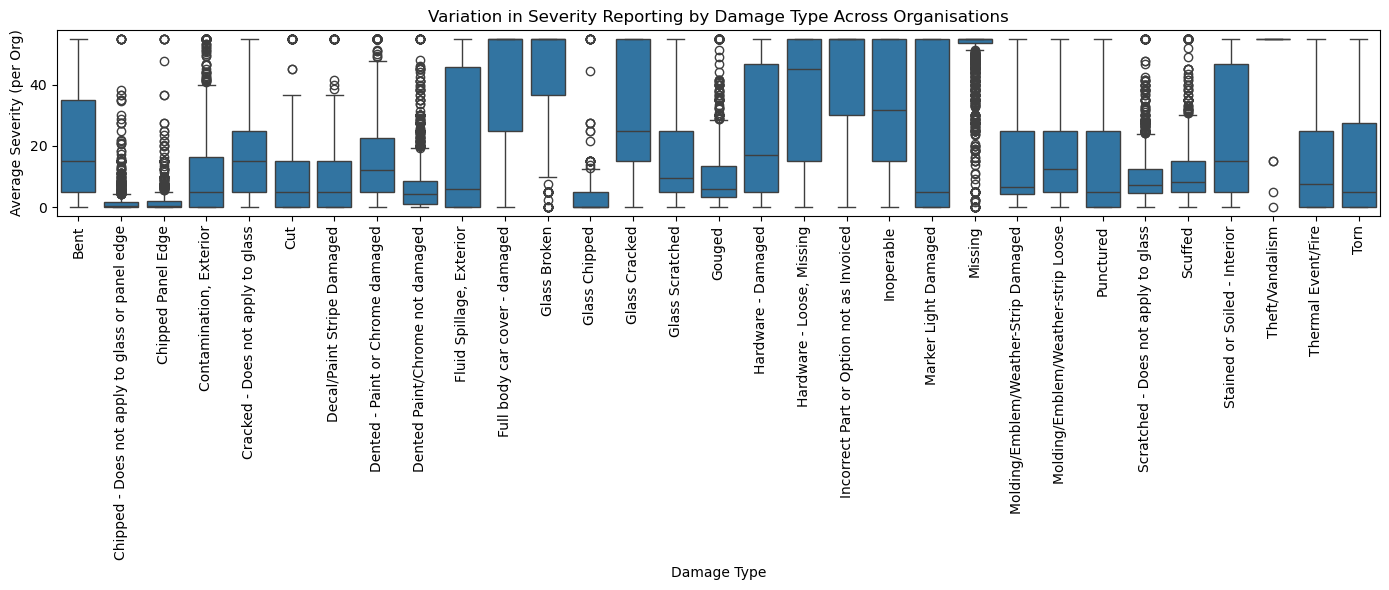

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter only rows where damage was actually found
damage_data = data[data['DefectsFound'].str.lower() == 'yes'].copy()

# 2. Drop rows with missing damage type or inspection org
damage_data = damage_data.dropna(subset=['Damage', 'Inspection Organisation', 'Severity_Weight'])

# 3. Group by Damage Type and Inspection Organisation
group = damage_data.groupby(['Damage', 'Inspection Organisation']).agg(
    Avg_Severity=('Severity_Weight', 'mean'),
    Report_Count=('Severity_Weight', 'count')
).reset_index()

# 4. Calculate severity variation (STD) across orgs for each damage type
severity_std = group.groupby('Damage')['Avg_Severity'].agg(
    Severity_STD='std',
    Org_Count='count'
).reset_index().sort_values(by='Severity_STD', ascending=False)

# 5. Show top damage types with highest reporting variation
print("Damage Types with Highest Severity Variation Across Inspection Orgs:")
print(severity_std)

# 6. Optional Visualization — Boxplot for Severity Spread
plt.figure(figsize=(14, 6))
sns.boxplot(x='Damage', y='Avg_Severity', data=group)
plt.xticks(rotation=90)
plt.title('Variation in Severity Reporting by Damage Type Across Organisations')
plt.xlabel('Damage Type')
plt.ylabel('Average Severity (per Org)')
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

# Step 1: Drop nulls if necessary
filtered_data = data.dropna(subset=['Damage', 'Severity_Weight', 'Inspection Organisation'])

# Step 2: Calculate average severity (threshold) per damage type
avg_severity_per_damage = (
    filtered_data.groupby('Damage')['Severity_Weight']
    .median()
    .reset_index()
    .rename(columns={'Severity_Weight': 'Avg_Severity_Threshold'})
)

# Round to nearest integer
avg_severity_per_damage['Avg_Severity_Threshold'] = avg_severity_per_damage['Avg_Severity_Threshold'].round(0).astype(int)

# Step 3: Calculate average severity per organisation for each damage type
org_severity = (
    filtered_data.groupby(['Damage', 'Inspection Organisation'])['Severity_Weight']
    .mean()
    .reset_index()
    .rename(columns={'Severity_Weight': 'Org_Avg_Severity'})
)

# Round to nearest integer
org_severity['Org_Avg_Severity'] = org_severity['Org_Avg_Severity'].round(0).astype(int)

# Step 4: Merge with the threshold table
comparison = pd.merge(org_severity, avg_severity_per_damage, on='Damage')

# Step 5: Classify companies as Over-reporting or Under-reporting
def classify(row):
    if row['Org_Avg_Severity'] > row['Avg_Severity_Threshold']:
        return 'Over-reporting'
    elif row['Org_Avg_Severity'] < row['Avg_Severity_Threshold']:
        return 'Under-reporting'
    else:
        return 'Average'

comparison['Reporting_Behavior'] = comparison.apply(classify, axis=1)

# Step 6: Show sample
comparison.head(10)


,Damage,Inspection Organisation,Org_Avg_Severity,Avg_Severity_Threshold,Reporting_Behavior
0,Bent,ATN Autoterminal Neuss,39,15,Over-reporting
1,Bent,AUTOS J G PINARD & FILS LTEE,8,15,Under-reporting
2,Bent,AandD Brennen Motor Sales and Serv,29,15,Over-reporting
3,Bent,Aaron Ford of Escondido,15,15,Average
4,Bent,Ace Motor Sales Inc.,55,15,Over-reporting
5,Bent,Adampol JSC - Poland,0,15,Under-reporting
6,Bent,Akins Ford,55,15,Over-reporting
7,Bent,Al Packer Ford Royal Palm Beach,55,15,Over-reporting
8,Bent,Al Packer's White Marsh Ford LLC,25,15,Over-reporting
9,Bent,Alan Jay Ford,55,15,Over-reporting


In [42]:
comparison.to_csv("comparison.csv", index=False)

In [43]:
# Group the table
grouped_summary = comparison.groupby(['Damage', 'Reporting_Behavior'])['Inspection Organisation'] \
    .apply(list).unstack(fill_value=[]).reset_index()
grouped_summary = grouped_summary.drop(columns=['Average'])

# Add the threshold column
thresholds = comparison[['Damage', 'Avg_Severity_Threshold']].drop_duplicates()
grouped_summary = grouped_summary.merge(thresholds, on='Damage')

# Rename columns for clarity
grouped_summary.columns = ['Damage', 'Over-reporting Orgs', 'Under-reporting Orgs', 'Avg Severity Threshold']

# Reorder columns
grouped_summary = grouped_summary[['Damage', 'Avg Severity Threshold', 'Over-reporting Orgs', 'Under-reporting Orgs']]

grouped_summary['# Over-reporting Orgs'] = grouped_summary['Over-reporting Orgs'].apply(len)
grouped_summary['# Under-reporting Orgs'] = grouped_summary['Under-reporting Orgs'].apply(len)


# Show result
grouped_summary


,Damage,Avg Severity Threshold,Over-reporting Orgs,Under-reporting Orgs,# Over-reporting Orgs,# Under-reporting Orgs
0,Bent,15,"[ATN Autoterminal Neuss, AandD Brennen Motor S...","[AUTOS J G PINARD & FILS LTEE, Adampol JSC - P...",378,370
1,Chipped - Does not apply to glass or panel edge,0,"[ANIL HARRYPERSAD, ATN Autoterminal Neuss, Aan...",[],778,0
2,Chipped Panel Edge,0,"[440 Ford Lincoln, A & B FORD SALES LTD., A. C...",[],728,0
3,"Contamination, Exterior",0,"[440 Ford Lincoln, ATN Autoterminal Neuss, Aan...",[],743,0
4,Cracked - Does not apply to glass,15,"[ATN Autoterminal Neuss, Aaron Ford of Escondi...","[440 Ford Lincoln, A & B FORD SALES LTD., AUTO...",281,352
5,Cut,5,"[ATN Autoterminal Neuss, Aaron Ford of Escondi...","[AandD Brennen Motor Sales and Serv, Aaron For...",143,172
6,Decal/Paint Stripe Damaged,5,"[ATN Autoterminal Neuss, Aaron Ford of Escondi...","[Aaron Ford of Poway, Advantage Ford Sales Ltd...",111,136
7,Dented - Paint or Chrome damaged,5,"[ANIL HARRYPERSAD, ATN Autoterminal Neuss, AUT...","[Aberle Ford Inc, Advantage Ford Sales Ltd, Al...",1215,345
8,Dented Paint/Chrome not damaged,0,"[440 Ford Lincoln, ANIL HARRYPERSAD, ATN Autot...",[],1213,0
9,"Fluid Spillage, Exterior",0,"[440 Ford Lincoln, AUTOS J G PINARD & FILS LTE...",[],137,0


In [44]:
grouped_summary.to_csv("reporting_behavior_summary.csv", index=False)